# Cart Pole Balancing

In [5]:
import numpy as np
import gym
import random
import time
import math
from collections import defaultdict
import matplotlib.pyplot as plt


# Define the QLearningAgent class
class QLearningAgent:
    
    # Initialisation
    def __init__(self, action_space, state_space, alpha, epsilon, gamma, decay_rate, min_epsilon):
        # State action space
        self.action_space = action_space
        self.state_space = state_space
        # Parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        # Lists and dictionaries
        self.q_table = defaultdict(lambda: np.zeros(self.action_space)) # Dictionary with only 0s
        self.all_losses = [] # Empty list
        self.win_rates = []
        self.win_counts = []
        self.all_rewards = []
        self.optimal_policy = {}
    
  
    def select_action(self, state):
        """
        Select action based on epsilon-greedy exploration
        :param state: Current state
        :return state: Action to take
        """
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.action_space)) # Exploration
        else:
            return np.argmax(self.q_table[state]) # Exploitation
    
    
    def update_q_value(self, state, action, reward, next_state):
        """
        Update the Q-table with maximal Q-value.
        :param state: Current state
        :param action: Action take
        :param reward: Reward received
        :param next_state: Next state reached
        
        """
        best_next_action = np.argmax(self.q_table[next_state])
        TD_target = reward + self.gamma * self.q_table[next_state][best_next_action] # Temporal difference
        TD_error = TD_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * TD_error
        
        # Calculate the loss
        loss = TD_error**2
        self.all_losses.append(loss)

 
    def decay_epsilon(self):
        """ Decay exploration rate """
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.decay_rate
        else:
            self.epsilon = self.min_epsilon
            
    def reset(self):
        """ Reset Q-table. Useful for episodic games """
        self.q_table = defaultdict(lambda: np.zeros(self.action_space))

        
    def get_q_table(self):
        """ Get Q-table """
        return dict(self.q_table)

In [6]:
# Initialise the environment
env = gym.make("CartPole-v1")
#print(env.action_space.n)

# Hyperparameters
alpha = 0.1
gamma = 0.95
epsilon = 1.0
min_epsilon = 0.05
episodes = 500000  # Reduced number of episodes for testing
total = 0
total_reward = 0
prior_reward = 0

# Observation space discretisation
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

# Decay rate for epsilon
decay_rate = 0.99995

# Observation space size for discretisation
observation_space_size = [30, 30, 50, 50]

# Initialise Q-learning agent
agent = QLearningAgent(action_space=env.action_space.n,
                       state_space=observation_space_size,
                       alpha=alpha,
                       epsilon=epsilon,
                       gamma=gamma,
                       decay_rate=decay_rate,
                       min_epsilon=min_epsilon)

# Function to convert continuous state to discrete state
def get_discrete_state(state):
    discrete_state = state / np_array_win_size + np.array([15, 10, 1, 10])
    return tuple(discrete_state.astype(int))

# Main loop for training the agent
for episode in range(episodes + 1):
    t0 = time.time()
    initial_state, _ = env.reset()
    state = initial_state
    discrete_state = get_discrete_state(state)
    done = False
    episode_reward = 0

    if episode % 2000 == 0: 
        print(f"Episode: {episode}")

    while not done: 
        action = agent.select_action(discrete_state)
        new_state, reward, done, truncated, _ = env.step(action)
        episode_reward += reward
        new_discrete_state = get_discrete_state(new_state)

        if episode % 2000 == 0:
            env.render()

        if not done and not truncated:
            agent.update_q_value(discrete_state, action, reward, new_discrete_state)

        discrete_state = new_discrete_state

    agent.decay_epsilon()
    agent.all_rewards.append(episode_reward)

    t1 = time.time()
    episode_total = t1 - t0
    total += episode_total

    total_reward += episode_reward
    prior_reward = episode_reward

    if episode % 1000 == 0:
        mean = total / 1000
        print(f"Time Average: {mean}")
        total = 0

        mean_reward = total_reward / 1000
        print(f"Mean Reward: {mean_reward}")
        total_reward = 0

env.close()

Episode: 0
Time Average: 1.2167930603027344e-05
Mean Reward: 0.035
Time Average: 0.0003710291385650635
Mean Reward: 22.613
Episode: 2000
Time Average: 0.0003621044158935547
Mean Reward: 22.461
Time Average: 0.00039643073081970214
Mean Reward: 23.425
Episode: 4000
Time Average: 0.0004093508720397949
Mean Reward: 24.159
Time Average: 0.0004309506416320801
Mean Reward: 26.258
Episode: 6000
Time Average: 0.00044991970062255857
Mean Reward: 27.357
Time Average: 0.0004841053485870361
Mean Reward: 29.272
Episode: 8000
Time Average: 0.0005271697044372559
Mean Reward: 31.515
Time Average: 0.0005918676853179932
Mean Reward: 34.517
Episode: 10000
Time Average: 0.0006218605041503906
Mean Reward: 37.598
Time Average: 0.0006772329807281495
Mean Reward: 40.417
Episode: 12000
Time Average: 0.0008130929470062256
Mean Reward: 45.56
Time Average: 0.000783503532409668
Mean Reward: 46.477
Episode: 14000
Time Average: 0.0009568336009979249
Mean Reward: 56.593
Time Average: 0.0009678869247436524
Mean Reward:

Time Average: 0.0037214484214782716
Mean Reward: 195.115
Episode: 130000
Time Average: 0.004013466119766235
Mean Reward: 205.889
Time Average: 0.004219674348831177
Mean Reward: 208.887
Episode: 132000
Time Average: 0.00379075288772583
Mean Reward: 205.307
Time Average: 0.003850945472717285
Mean Reward: 207.414
Episode: 134000
Time Average: 0.004130232095718384
Mean Reward: 207.11
Time Average: 0.0041692802906036375
Mean Reward: 216.223
Episode: 136000
Time Average: 0.005055318593978882
Mean Reward: 218.209
Time Average: 0.004269365549087524
Mean Reward: 221.606
Episode: 138000
Time Average: 0.004274063587188721
Mean Reward: 222.467
Time Average: 0.003999181032180786
Mean Reward: 219.743
Episode: 140000
Time Average: 0.003699531078338623
Mean Reward: 202.028
Time Average: 0.0037692375183105468
Mean Reward: 204.952
Episode: 142000
Time Average: 0.0038178486824035646
Mean Reward: 210.752
Time Average: 0.004269413471221924
Mean Reward: 216.658
Episode: 144000
Time Average: 0.00426378202438

Time Average: 0.004148065090179443
Mean Reward: 217.08
Episode: 258000
Time Average: 0.0043100275993347165
Mean Reward: 215.918
Time Average: 0.004060838460922241
Mean Reward: 219.709
Episode: 260000
Time Average: 0.004212116718292237
Mean Reward: 220.028
Time Average: 0.004318444013595581
Mean Reward: 217.251
Episode: 262000
Time Average: 0.003966431617736816
Mean Reward: 217.478
Time Average: 0.003866311311721802
Mean Reward: 213.94
Episode: 264000
Time Average: 0.004176764726638794
Mean Reward: 215.392
Time Average: 0.004488178491592407
Mean Reward: 218.593
Episode: 266000
Time Average: 0.004094590663909912
Mean Reward: 219.914
Time Average: 0.004873624324798584
Mean Reward: 222.668
Episode: 268000
Time Average: 0.004049841165542602
Mean Reward: 212.091
Time Average: 0.004019899368286133
Mean Reward: 217.218
Episode: 270000
Time Average: 0.004333606481552124
Mean Reward: 224.394
Time Average: 0.004789049625396728
Mean Reward: 224.416
Episode: 272000
Time Average: 0.00406894540786743

Episode: 386000
Time Average: 0.004145317077636719
Mean Reward: 210.289
Time Average: 0.004778475522994995
Mean Reward: 203.435
Episode: 388000
Time Average: 0.004122323751449585
Mean Reward: 212.379
Time Average: 0.0041692121028900145
Mean Reward: 221.202
Episode: 390000
Time Average: 0.0041752042770385744
Mean Reward: 218.826
Time Average: 0.004064592123031616
Mean Reward: 219.052
Episode: 392000
Time Average: 0.004028399229049682
Mean Reward: 217.821
Time Average: 0.0038381242752075196
Mean Reward: 209.086
Episode: 394000
Time Average: 0.003777500629425049
Mean Reward: 204.201
Time Average: 0.004172412633895874
Mean Reward: 201.56
Episode: 396000
Time Average: 0.004167401313781739
Mean Reward: 207.436
Time Average: 0.003728123903274536
Mean Reward: 200.519
Episode: 398000
Time Average: 0.0038521764278411866
Mean Reward: 213.481
Time Average: 0.0037731096744537352
Mean Reward: 209.618
Episode: 400000
Time Average: 0.004167547225952148
Mean Reward: 230.93
Time Average: 0.0042496922016

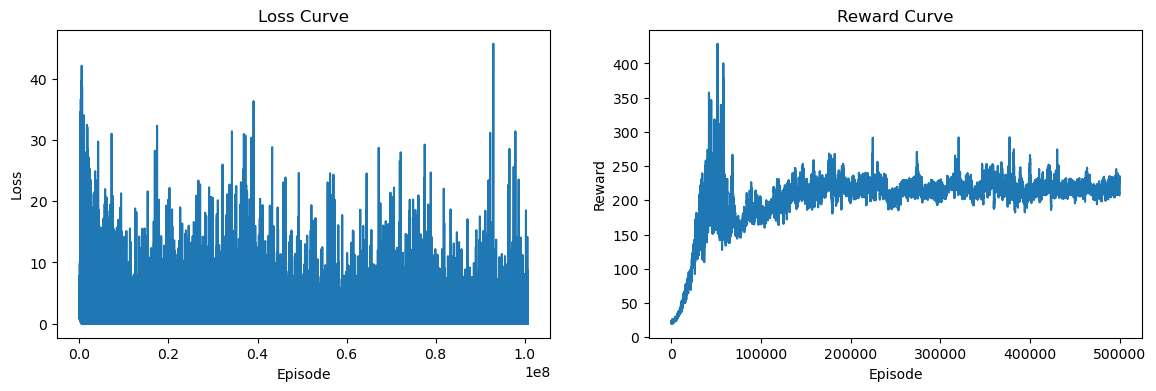

In [7]:

# Function to calculate the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Calculate the moving average with a window size of 100
smoothed_losses = moving_average(agent.all_losses, 100)
smoothed_rewards = moving_average(agent.all_rewards, 100)

# Plotting the loss and reward curves
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(smoothed_losses)
plt.title("Loss Curve")
plt.xlabel("Episode")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(smoothed_rewards)
plt.title("Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.show()